In [1]:
import nltk
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [2]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


In [3]:
sns.set_context('talk')

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

# Data

In [6]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
class_corpus = get_corpus_df(CORPUS_PATH)


In [7]:
class_corpus.loc[class_corpus['Student Name'] == 'BYM']

,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,Descriptor,Doc_ID
Doc_ID,,,,,,,,,
152,BYM_Doc3_EQUILIBRIUM,"A tedious rip-off sci-fi film , itching to be ...",BYM_Doc3_EQUILIBRIUM,BYM,Sci-Fi,Negative,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_N_152,152
155,BYM_Doc6_EQUILIBRIUM,`` Equilibrium '' is like a remake of `` 1984 ...,BYM_Doc6_EQUILIBRIUM,BYM,Sci-Fi,Negative,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_N_155,155
156,BYM_Doc7_EQUILIBRIUM,An unsophisticated sci-fi drama that takes its...,BYM_Doc7_EQUILIBRIUM,BYM,Sci-Fi,Negative,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_N_156,156
157,BYM_Doc8_EQUILIBRIUM,Science fiction is a good genre for creating v...,BYM_Doc8_EQUILIBRIUM,BYM,Sci-Fi,Negative,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_N_157,157
158,BYM_Doc9_EQUILIBRIUM,The worst theatrically released sci-fi flick s...,BYM_Doc9_EQUILIBRIUM,BYM,Sci-Fi,Negative,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_N_158,158
150,BYM_Doc1_EQUILIBRIUM,Equilibrium is my favorite movie of 2002 . It ...,BYM_Doc1_EQUILIBRIUM,BYM,Sci-Fi,Positive,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_P_150,150
151,BYM_Doc2_EQUILIBRIUM,If I was to explain this movie to someone in o...,BYM_Doc2_EQUILIBRIUM,BYM,Sci-Fi,Positive,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_P_151,151
153,BYM_Doc4_EQUILIBRIUM,If you were disappointed by recent sci-fi acti...,BYM_Doc4_EQUILIBRIUM,BYM,Sci-Fi,Positive,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_P_153,153
154,BYM_Doc5_EQUILIBRIUM,`` Equilibrium '' would be a mindless action p...,BYM_Doc5_EQUILIBRIUM,BYM,Sci-Fi,Positive,EQUILIBRIUM,Sci-Fi_EQUILIBRIUM_P_154,154


In [8]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB


# Preprocessing

In [9]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

In [10]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    custom_stop_words = ['movies', 'movie', 'film', 'films', 'scene']
    STOP_WORDS.update(custom_stop_words)
    return [w for w in tokenized_text if not w in STOP_WORDS]

In [11]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

In [12]:
def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)

    return tokenized_text

In [13]:
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

In [14]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

In [15]:
class_corpus['normalized_review'] = class_corpus['Text'].apply(normalize)
class_corpus['tokenized_review'] = class_corpus['normalized_review'].apply(tokenize)
class_corpus['lemmatized_tokens'] = class_corpus['tokenized_review'].apply(lemmatize)
class_corpus['lemmatized_text'] = class_corpus['lemmatized_tokens'].apply(join_tokens)

In [16]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
 9   normalized_review         200 non-null    object
 10  tokenized_review          200 non-null    object
 11  lemmatized_tokens         200 non-null    object
 12  lemmatized_text           200 non-null    object
dtypes: int64(1), object(12)
memory usage: 21.9+ KB


# Feature Extraction

## Method 1: TF-IDF

In [17]:
tfidf_vectorizer = TfidfVectorizer()

In [18]:
dtm_class_corpus = tfidf_vectorizer.fit_transform(class_corpus['lemmatized_text'])

In [19]:
features_tfidf_scores = pd.DataFrame(dtm_class_corpus.toarray(),
                                     columns=tfidf_vectorizer.get_feature_names_out(),
                                     index=class_corpus.index)

In [20]:
features_tfidf_scores.shape

(200, 10077)

## Method 2: Doc2Vec

In [21]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(class_corpus.lemmatized_tokens)]

In [22]:
model_doc2vec = Doc2Vec(documents,
                        vector_size=200,
                        min_count=1,
                        workers=4)

In [23]:
features_doc2vec = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    features_doc2vec = pd.concat([features_doc2vec, vector])

In [24]:
features_doc2vec.shape

(200, 200)

# Clustering

Before clustering, we need to scale the data to bring parity between all the columns.

In [25]:
standard_scaler = StandardScaler()

In [26]:
transformed_features_doc2vec = standard_scaler.fit_transform(features_doc2vec)

In [27]:
model_kmeans = KMeans(n_clusters=4,
                      random_state=20130810)

In [28]:
model_kmeans.fit(transformed_features_doc2vec)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=20130810)

In [29]:
labels_kmeans = model_kmeans.labels_

Quality of clustering is determined using the [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

In [30]:
silhouette_score(transformed_features_doc2vec, labels_kmeans)

0.37780994

In [31]:
for k in [4, 5, 6, 7, 8, 9]:

    model_kmeans = KMeans(n_clusters=k,
                          random_state=20130810,
                          n_init=10)
    model_kmeans.fit(transformed_features_doc2vec)
    sil_score = silhouette_score(transformed_features_doc2vec, model_kmeans.labels_)
    print(f"k = {k}, silhouette score = {sil_score}")

k = 4, silhouette score = 0.37780994176864624
k = 5, silhouette score = 0.3729080855846405
k = 6, silhouette score = 0.3649110794067383
k = 7, silhouette score = 0.3031095266342163
k = 8, silhouette score = 0.29648905992507935
k = 9, silhouette score = 0.26734232902526855


In [32]:
model_kmeans = KMeans(n_clusters=4)
model_kmeans.fit(transformed_features_doc2vec)
labels_kmeans = model_kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [33]:
model_tsne = TSNE(n_components=2)

In [34]:
transformed_values = model_tsne.fit_transform(transformed_features_doc2vec)
X, Y = [], []

for value in transformed_values:
    X.append(value[0])
    Y.append(value[1])

In [40]:
len(transformed_values)

200

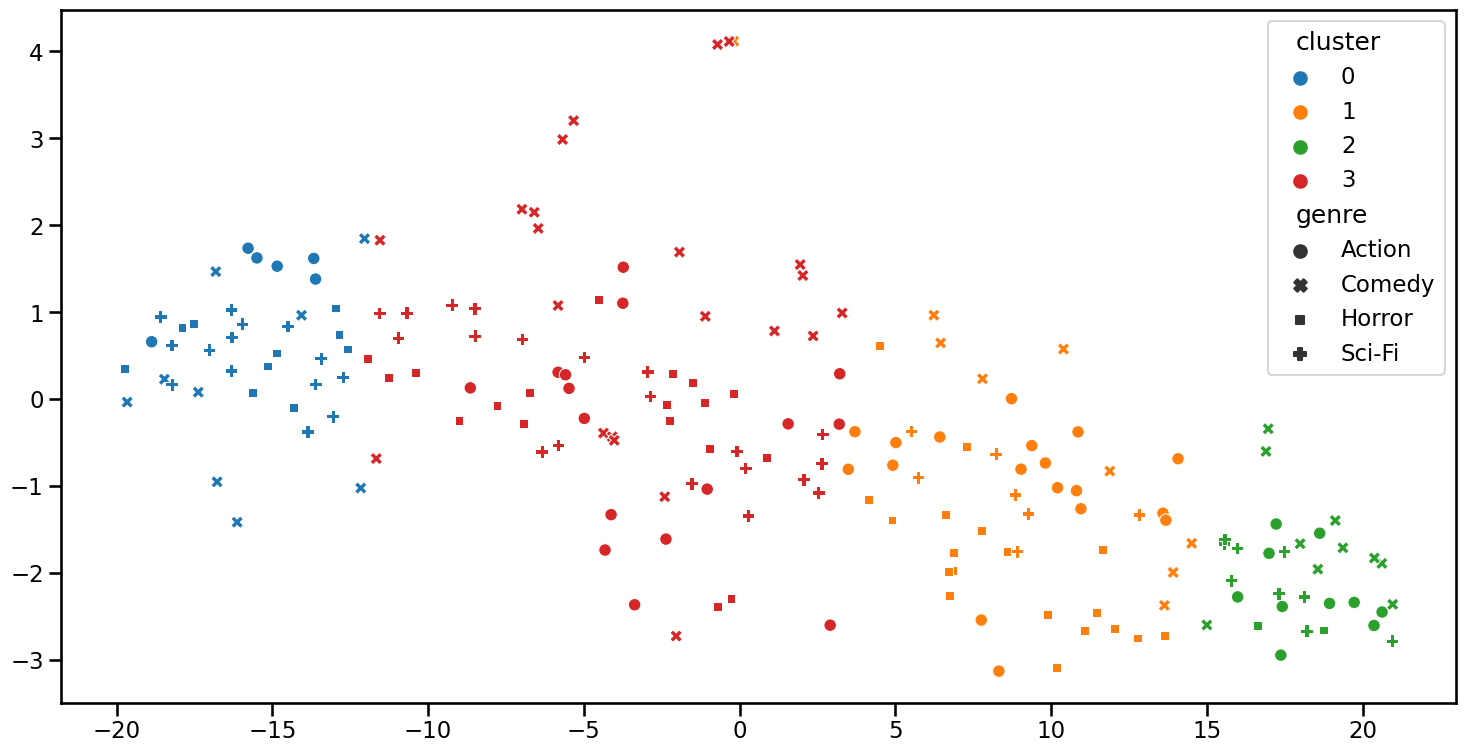

In [51]:
genres = class_corpus['Genre of Movie'].to_list()
plt.figure(figsize=(18, 9))

labels_kmeans_str = pd.Series(labels_kmeans.astype(str), name='cluster')
genres_kmeans_str = pd.Series(genres, name='genre')

sns.scatterplot(x=X,
                y=Y,
                hue=labels_kmeans_str,
                hue_order=['0', '1', '2', '3'],
                style=genres_kmeans_str);

Once the cluster assignment is done, we can then look at the composition of the clusters to qualitatively assess the clusters.

In [37]:
documents_by_cluster = (class_corpus.loc[:, ['DSI_Title', 'Genre of Movie', 'Text']]
                                    .assign(cluster_label=labels_kmeans))

In [38]:
documents_by_cluster.query(f"cluster_label == 1")

,DSI_Title,Genre of Movie,Text,cluster_label
Doc_ID,,,,
95,LKP_Doc6_Angel_has_fallen,Action,"As I left the theater the other night , I bega...",1
98,LKP_Doc9_Angel_has_fallen,Action,American movie presidents can only make us wis...,1
85,SHR_Doc6_Inception,Action,Contrary to the opinions of the deluded army o...,1
87,SHR_Doc8_Inception,Action,I had the misfortune of choosing to squander b...,1
89,SHR_Doc10_Inception,Action,Christopher Nolan has done some great work . H...,1
80,SHR_Doc1_Inception,Action,I 'm nearly at a loss for words . Just when yo...,1
53,BKG_Doc4_No_Time_to_Die,Action,"From `` Lawrence of Arabia '' to `` Iron Man ,...",1
54,BKG_Doc5_No_Time_to_Die,Action,It 's been more than a year since No Time to D...,1
71,DHB_Doc2_Taken,Action,"I 've never written a review before , but this...",1


In [39]:
pd.set_option('display.max_rows', None)
documents_by_cluster.sort_values(by=['cluster_label', 'Genre of Movie', 'DSI_Title'], ascending=True)

,DSI_Title,Genre of Movie,Text,cluster_label
Doc_ID,,,,
51,BKG_Doc2_No_Time_to_Die,Action,For those whose cinematic consciousness predat...,0
56,BKG_Doc7_No_Time_to_Die,Action,As Robert Graves wrote when he was ridding him...,0
57,BKG_Doc8_No_Time_to_Die,Action,"Nothing can truly kill James Bond , but the CO...",0
90,LKP_Doc1_Angel_has_fallen,Action,Target is on the move . '' Heavily outnumbered...,0
91,LKP_Doc2_Angel_has_fallen,Action,"The sleepy , dopey action bonanza `` Angel Has...",0
97,LKP_Doc8_Angel_has_fallen,Action,Gerard Butler continues to burnish his brand o...,0
11,HBI_Doc2_Holmes_and_Watson,Comedy,"Dear eight-pound , six-ounce , newborn baby Je...",0
12,HBI_Doc3_Holmes_and_Watson,Comedy,The comedy so execrable that audiences evacuat...,0
14,HBI_Doc5_Holmes_and_Watson,Comedy,One of the year 's most critically shellacked ...,0


# Conclusion

Quality of features extracted from text (e.g., `tf-idf` and `doc2vec`) can be acertained by the quality of the clusters generated using these features. These clusters also highlight potential patterns within the corpus.
